# Valoración de Opciones Americanas

In [2]:
import numpy as np
from matplotlib import pyplot as plt

### Simulación de proceso GBM

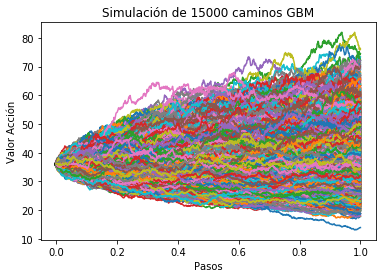

CPU times: user 2min 24s, sys: 944 ms, total: 2min 25s
Wall time: 2min 26s


In [18]:
%%time
T = 1 # Tiempo Madurez, 1 año
N = 1000  # Numero de pasos [oportunidades de ejecutar en Americanas]
dt = T/(N-1) # Intervalos de tiempo
r = 0.06 # Tasa de interes libre de riesgo
sigma = 0.2
S0 = 36 # Valor inicial de la acción
K = 40 
factor_descuento_madurez = np.exp(-r *N*dt)
factor_descuento_dt= np.exp(-r*dt)


def generar_camino_gbm (T, r, sigma, S0, dt):
    '''
    Funcion que genera arreglo con trayectoria GBM
    '''
    
    n = round(T/dt)
    t = np.linspace(0, T, n)
    W = [0] + np.random.standard_normal(size = n) 
    W = np.cumsum(W)*np.sqrt(dt) # Movimiento Browniano usual
    X = (r-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) # GBM
    plt.plot(t, S)
    
    return S


N = 15000 #  Cantidad Caminos
caminos_gbm = []
for i in range(0,N-1):
    caminos_gbm.append(generar_camino_gbm(T, r, sigma, S0, dt))
    
plt.title('Simulación de {} caminos GBM'.format(N))
plt.xlabel('Pasos')
plt.ylabel('Valor Acción')
plt.show()



### Valor de Opción Europea - Call con estos caminos

In [84]:
print("Numero de caminos: ", N)
print("Promedio payoff en distintos caminos descontado", 
      factor_descuento_madurez*np.average([np.maximum(0, K-x[-1]) for x in caminos_gbm]))

caminos_no_payoff = len([x for x in [np.maximum(0, K-x[-1]) for x in caminos_gbm] if x == 0])
print("Caminos con pay-off = 0 : ", caminos_no_payoff, caminos_no_payoff/len(caminos_gbm)  )



Numero de caminos:  15000
Promedio payoff en distintos caminos descontado 3.841282600456948
Caminos con pay-off = 0 :  5546 0.36975798386559106


### Calcular valor de Opción Americana a partir de caminos simulados, para ciertos parámetros

In [101]:
caminos_gbm = np.array(caminos_gbm)
pay_offs = np.maximum(K - np.array(caminos_gbm), 0)
V = np.zeros_like(pay_offs)      
V[:,-1] = pay_offs[:,-1]

# Valoracion mediante metodo LSE

for t in range(len(pay_offs[0])-2, 0, -1): 
    
    camino_bueno = pay_offs[:,t] > 0  # Encontrar momentos con pay-off positivo en t
    rg = np.polyfit( caminos_gbm[camino_bueno, t], V[camino_bueno, t + 1] , 2) # Regresion Polinomial
    C = np.polyval(rg, caminos_gbm[camino_bueno,t+1])  # Calcular valor de continuacion

    
    vector_ejercitar = np.zeros(len(camino_bueno), dtype=bool)    
    vector_ejercitar[camino_bueno] = pay_offs[camino_bueno,t] > C        
    
    V[vector_ejercitar,t] = caminos_gbm[vector_ejercitar,t]                
    V[vector_ejercitar,t+1:] = 0                               
    discount_path = (V[:,t] == 0)     
    
    V[discount_path,t] = V[discount_path,t+1] * factor_descuento_dt  
    
V0 = np.mean(V[:,1])*(factor_descuento_dt) 
print("Valor presente ejercitar pay-off promedio de caminos: ", V0)

Valor presente ejercitar pay-off promedio de caminos:  12.044166892281888


### TODOs

In [72]:
### Simular usando un proceso de difusión, o otros procesos.

In [73]:
### Comparar resultados cona gluna librería